<img src="./logo_UNSAM.jpg" align= "right" width= "150" /> -->
## APS
## Trabajo práctico semanal 4: Primeras nociones de estimación espectral
### Violeta Manterola

Para una señal: 
$$
x(n)=a_1⋅sen(Ω_1⋅n)+n_a(n)
$$
siendo $Ω_1=Ω_0+fr⋅2πN$ y $Ω_0=\frac{π}{2}$
y las variables aleatorias definidas por $$fr∼U(-0.5,0.5)$$ $$n_a∼N(0,σ^{2})$$

Evalúe los siguientes estimadores de $a_1$ y $Ω_1$

$$\hat{a_1^i}=|X_w^{i}(Ω_0)|=|F{x(n)⋅w_i(n)}|$$

$$\hat{Ω_1^i}=arg max{{|X^{i}_w(Ω)|}}$$

para la i-ésima ventana que analice:

-  rectangular (sin ventana), 
-  flattop 
-  blackmanharris
-  otras que analice
Y siguiendo las siguientes consignas para su experimentación:
Considere 200 realizaciones de 1000 muestras para cada experimento.
Parametrice para SNR's de 3 y 10 db (Ayuda: calibre a1 para que la potencia de la senoidal sea 1W).

Se pide:
1) Realizar una tabla por cada SNR, que describa el sesgo y la varianza de cada estimador para cada ventana analizada. Recuerde incluir las ventanas rectangular (sin ventana), flattop y blackmanharris y otras que considere.

Bonus:
💎 Analice el efecto del zero-padding para el estimador $\hat{Ω_1}$
 

-----------------------------------------------------------------------------------------------------------------------------------------------

En este trabajo el objetivo es analizar la estimación espectral de potencia de una señal ruidosa (con ruido aleatorio), mediante el uso de estimadores de amplitud y frecuencia. Así como también se implemeta el uso de ventanas temporales, las cuáles permiten reducir el leakage (fuga esepctral) que suele tener la señal cuadrada, ya que la tranformada de fourier de la misma es una sinc cuyos lóbulos laterales no son despreciables. Es decir, el método de ventaner busca suavizar estos lóbulos laterales, buscando así que la energía de la señal se concentre mejor en la frecuencia real. 
Sin embargo, como se espera observar en el desarollo de este trabajo, resulta que al concentrar más la energía se pierde resolución, terminanda ensanchando el lóbulo central. 
En cuanto a los estimadores:
-  Estimador de amplitud: mide cuato vale la amplitud máxima en el dominio de la frecuencia. En este caso, se configura una frecuecnaide muestreo de 1kHz por lo tanto, se espera que sea en 250Hz. 
-  Estimador de frecuencia: estima a que frecuencia aparece el valor máximo del espectro.
En este caso se analizaron disitntos tipos de ventanas temporales, las cuales modifican de distinta manera el espectro para poder controlar la energía. Ventanas a utilizar:
      -  Cuadrada
      -  Blackhamming
      -  Flattop
      -  Hamming
      -  Bartlett

Por último, se analizará el uso del zero-padding, una técnica que no modfica la información sino que agrega ceros a la señal para obtener una mejor resolución. 

Primero se evalúa con SNR de 3 y 10 dB, comparando ambos resultados, y luego como se espera que no haya suficiente resolución espectral, se realiza el mismo caso pero aplicando el método de zero-padding donde se espera obtener una mejro resolución, pero a costa de la varianza. 


In [12]:
#%% Módulos
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal 
import pandas as pd #para la tabla de datos

# Parámetros generales / datos de simulación
fs = 1000  # Hz
N = 1000 #cantidad de muestras
ts = 1 / fs
df = fs / N
a1 = np.sqrt(2)  #amplitud de la señal, tal que la potencia de la senoidal sea de 1W.
R = 200  # cantidad repeticiones
w0 = fs / 4  #frecuencia central => mitad de banda digital

def analizar_ventanas(SNR, usar_zero_padding=False): # uso estos parametros xq son los únicos q voy a cambiar. Agrego lo de zero padding para la prox parte
    N_pad = N * 10 if usar_zero_padding else N # en caso de hacer zero-padding => la fft permite que si n>>N paddea los extremos con ceros. 
    df_pad= fs/N_pad if usar_zero_padding else df

    # Grilla temporal y frecuencias
    #frecuencia aleatoria
    fr = np.random.uniform(-1/2, 1/2, size=(1, R)) #para que tenga tamaño 1xR
    
    tt = np.linspace(0, (N - 1) * ts, N).reshape((N, 1))
    vtt = np.tile(tt, (1, R))#para q quede la matriz de de NxR, q me lo repite en la segunda dimension , osea me repite R veces algo que era N.
    w1 = w0 + fr * df 
    f_real = np.mean(w1) #para luego calcualar el estimador 

    #%% señal pura
    nn = a1 * np.sin(2 * np.pi * w1 * vtt)#debe quedar con dimensiones de [N,R]
    #%% generación ruido aleatorio 
    pot_ruido = 10 ** (-SNR / 10) 
    na = np.random.normal(0, np.sqrt(pot_ruido), size=(N, R)) #señal de ruido aleatorio, con dimensiones [N,R]
    #%% señal + ruido 
    sr = nn + na #sumo todo (ambas señales)

    #%%ventanas 
    ventana_0 = np.ones((N, 1)) #cuadrada sin ventana 
    ventana_1 = signal.windows.blackmanharris(N).reshape(N,1) #ventana blackmanharris
    ventana_2 = signal.windows.flattop(N).reshape(N,1) #ventana flattop
    ventana_3 = signal.windows.hamming(N).reshape(N,1) #ventana hamming
    ventana_4 = signal.windows.bartlett(N).reshape(N,1) #ventana Bartlett

    #%%aplico ventanas y calculo FFT´s
    signal_0 = sr * ventana_0 
    signal_0_fft = (1/N)*np.fft.fft(signal_0,n=N_pad, axis=0)
    signal_0_abs = np.abs(signal_0_fft)
    
    signal_1 = sr * ventana_1 #ventaneo (lo mismo con todas)
    signal_1_fft = (1/N)*np.fft.fft(signal_1,n=N_pad, axis=0)
    signal_1_abs = np.abs(signal_1_fft)
    
    signal_2 = sr * ventana_2
    signal_2_fft = (1/N)*np.fft.fft(signal_2,n=N_pad,axis=0)
    signal_2_abs = np.abs(signal_2_fft)
    
    signal_3 = sr * ventana_3
    signal_3_fft = (1/N)*np.fft.fft(signal_3,n=N_pad, axis=0)
    signal_3_abs = np.abs(signal_3_fft)
    
    signal_4 = sr * ventana_4 #ventaneo (lo mismo con todas)
    signal_4_fft = (1/N)*np.fft.fft(signal_4,n=N_pad, axis=0)
    signal_4_abs = np.abs(signal_4_fft)

    #%%estimador de amplitud
    est_amp_0=np.abs(signal_0_fft[N//4, :]) #en N//4 xq es la fercuencia central de la senoidal, donde se espera la mayor amplitud. la doble barra es para q sea un entero. 
    est_amp_1=np.abs(signal_1_fft[N//4, :])
    est_amp_2=np.abs(signal_2_fft[N//4, :])
    est_amp_3=np.abs(signal_3_fft[N//4, :])
    est_amp_4=np.abs(signal_4_fft[N//4, :])

    #%%estimador de freceuncia 
    #ahora busco donde la amplitud del espectro es maximo 
    omega_0=np.argmax(signal_0_abs[:N_pad//2, :],axis =0 ) #pongo N//2, tomo solo los positivos, puedo hacerlo ya que la fft es simétrica
    omega_1=np.argmax(signal_1_abs[:N_pad//2, :],axis =0 )
    omega_2=np.argmax(signal_2_abs[:N_pad//2, :],axis =0 )
    omega_3=np.argmax(signal_3_abs[:N_pad//2, :],axis =0 )
    omega_4=np.argmax(signal_4_abs[:N_pad//2, :],axis =0 )

    est_frec0 = omega_0*df_pad #para que me quede en frecuencia 
    est_frec1 = omega_1*df_pad
    est_frec2 = omega_2*df_pad
    est_frec3 = omega_3*df_pad
    est_frec4 = omega_4*df_pad

    def calcular_sesgo_varianza(est, valor_real): #lo caclulo para ambos estimadores
        sesgo = np.mean(est) - valor_real #definiendo sesgo como: valor esperado - valor real 
        varianza = np.var(est)
        return sesgo, varianza
    
    # pra el estimador de amplitud (valor real = a1)
    sesgo_amp_0, var_amp_0 = calcular_sesgo_varianza(est_amp_0, a1)
    sesgo_amp_1, var_amp_1 = calcular_sesgo_varianza(est_amp_1, a1)
    sesgo_amp_2, var_amp_2 = calcular_sesgo_varianza(est_amp_2, a1)
    sesgo_amp_3, var_amp_3 = calcular_sesgo_varianza(est_amp_3, a1)
    sesgo_amp_4, var_amp_4 = calcular_sesgo_varianza(est_amp_4, a1)
    
    # para el estimador de frecuencia (valor real = f_real)
    sesgo_frec_0, var_frec_0 = calcular_sesgo_varianza(est_frec0, f_real)
    sesgo_frec_1, var_frec_1 = calcular_sesgo_varianza(est_frec1, f_real)
    sesgo_frec_2, var_frec_2 = calcular_sesgo_varianza(est_frec2, f_real)
    sesgo_frec_3, var_frec_3 = calcular_sesgo_varianza(est_frec3, f_real)
    sesgo_frec_4, var_frec_4 = calcular_sesgo_varianza(est_frec4, f_real)

    #%%ploteos histogramas 
    if not usar_zero_padding: #porque luego cuando uso zero-padding, solo lo hago con el estimador de frecuencia. 
        plt.figure(figsize=(10, 6))
        plt.hist(est_amp_0, bins=30, alpha=0.5, color = 'black',label='Rectangular-sin ventana')
        plt.hist(est_amp_1, bins=30, alpha=0.5, color = 'purple',label='Blackman-Harris')
        plt.hist(est_amp_2, bins=30, alpha=0.5,color='orange', label='Flattop')
        plt.hist(est_amp_3, bins=30, alpha=0.5, color='blue',label='Hamming')
        plt.hist(est_amp_4, bins=30, alpha=0.5, color='green',label='Bartlett')
        
        plt.title("Histograma amplitud estimada")
        plt.xlabel(".")
        plt.ylabel("Número de ocurrencias")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    plt.figure(figsize=(10, 6))
    
    plt.hist(est_frec1, bins=30, alpha=0.4, color = 'purple',label='Blackman-Harris')
    plt.hist(est_frec2, bins=30, alpha=0.4,color='orange', label='Flattop')
    plt.hist(est_frec3, bins=30, alpha=0.4, color='blue',label='Hamming')
    plt.hist(est_frec4, bins=30, alpha=0.4, color='green',label='Bartlett')
    plt.hist(est_frec0, bins=30, alpha=0.4, color = 'black',label='Rectangular-sin ventana')
    
    plt.title("Histograma Frecuencias estimadas")
    plt.xlabel("Frecuencia estimada [Hz]")
    plt.ylabel("Número de ocurrencias")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Devuelvo los resultados en un diccionario para poder hacer la tabla despues
    if usar_zero_padding:
        resultados = {
            "Ventanas": ["Rectangular", "Blackman-Harris", "Flattop", "Hamming", "Bartlett"],
            "Est.Frecuencia-Sesgo": [sesgo_frec_0, sesgo_frec_1, sesgo_frec_2, sesgo_frec_3, sesgo_frec_4],
            "Est.Frecuencia-Varianza": [var_frec_0, var_frec_1, var_frec_2, var_frec_3, var_frec_4]
        }
    else:
        resultados = {
            "Ventanas": ["Rectangular", "Blackman-Harris", "Flattop", "Hamming", "Bartlett"],
            "Est.Amplitud-Sesgo": [sesgo_amp_0, sesgo_amp_1, sesgo_amp_2, sesgo_amp_3, sesgo_amp_4],
            "Est.Amplitud-Varianza": [var_amp_0, var_amp_1, var_amp_2, var_amp_3, var_amp_4],
            "Est.Frecuencia-Sesgo": [sesgo_frec_0, sesgo_frec_1, sesgo_frec_2, sesgo_frec_3, sesgo_frec_4],
            "Est.Frecuencia-Varianza": [var_frec_0, var_frec_1, var_frec_2, var_frec_3, var_frec_4]
        }

    return resultados

    


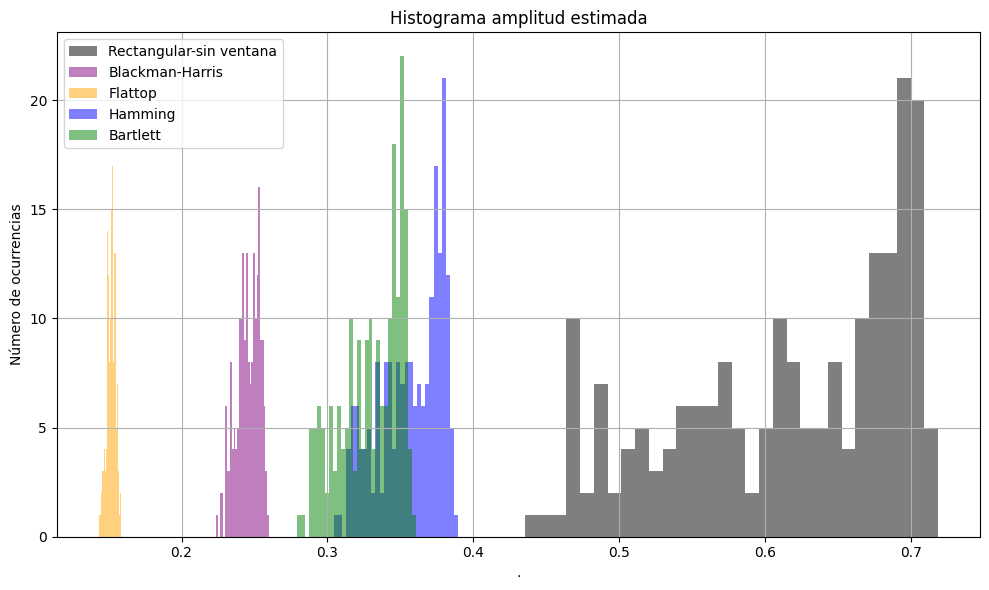

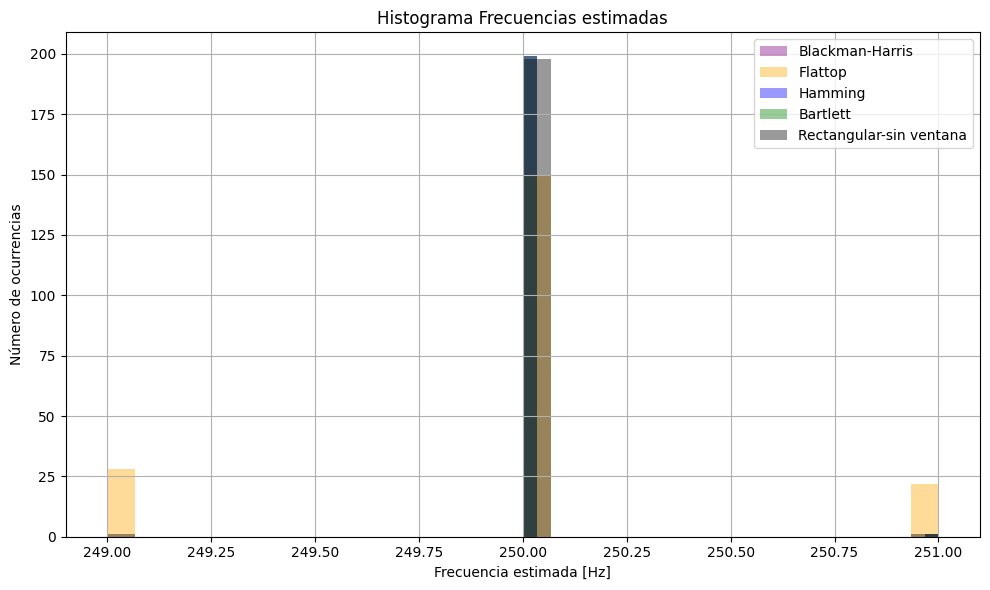

,Ventanas,Est.Amplitud-Sesgo,Est.Amplitud-Varianza,Est.Frecuencia-Sesgo,Est.Frecuencia-Varianza
0,Rectangular,-0.7988,0.0061,0.0011,0.0100
1,Blackman-Harris,-1.1689,0.0001,0.0061,0.0050
2,Flattop,-1.2622,0.0000,-0.0289,0.2491
3,Hamming,-1.0571,0.0005,0.0061,0.0050
4,Bartlett,-1.0844,0.0004,0.0061,0.0050


In [9]:
resultados_10db = analizar_ventanas(SNR=10)

# Para mostrar como tabla:
df_10db = pd.DataFrame(resultados_10db)
display(df_10db.round(4))


En esta primera situación, con **SNR= 10dB**, se observa:
- En cuanto al histograma de los estimadores de amplitud:
  -  Como se predecía en un principio, la ventana rectangular es muy dispersa, mientras que las que mejor estiman (se nota porque son aquellas mas estrechas) son la Flattop y la Blackmanharris; son las que menor varianza tienen (casi nula). Sin embargo, su valor se sesgo es mucho mayor, es decir, difieren del valor real en una mayor medida que el resto. Esto puede adjudicarsse a que "ensancha" su lóbulo central para poder "captar más energía" y  estimar mejor la amplitud, lo que resulta en un alejamiento del pico del valor real. 
  -  Por el otro lado,en el histograma de frecuencias estimadas vemos que aquella ventana con mayor varianza es la Flattop (en frecuencia), lo cual se relaciona con lo anterior. Es decir, la flattop es ideal para estimar la amplitud pero lo hace a costa de la freceuncia. Por lo tanto, se puede decir que para estimar la frecuencia es mejor utilizar la señal cuadrada o la Hammig.
  -  Cabe destacar que la resolución en el segundo histograma es muy baja, solo se ven representados 3 posibles puntos, es por esto que luego se aplica la técnica zero-padding para aumentarla. 

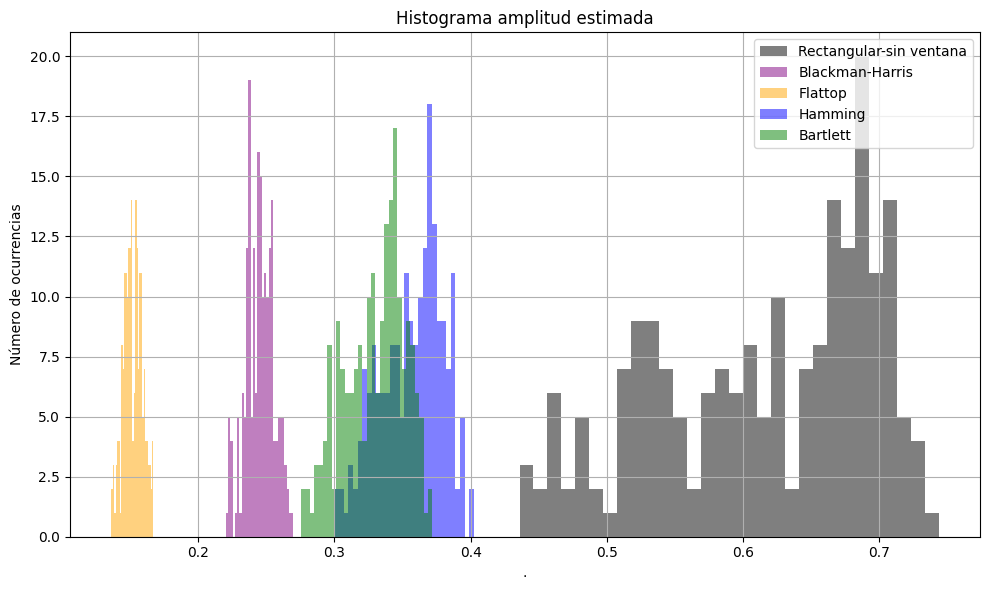

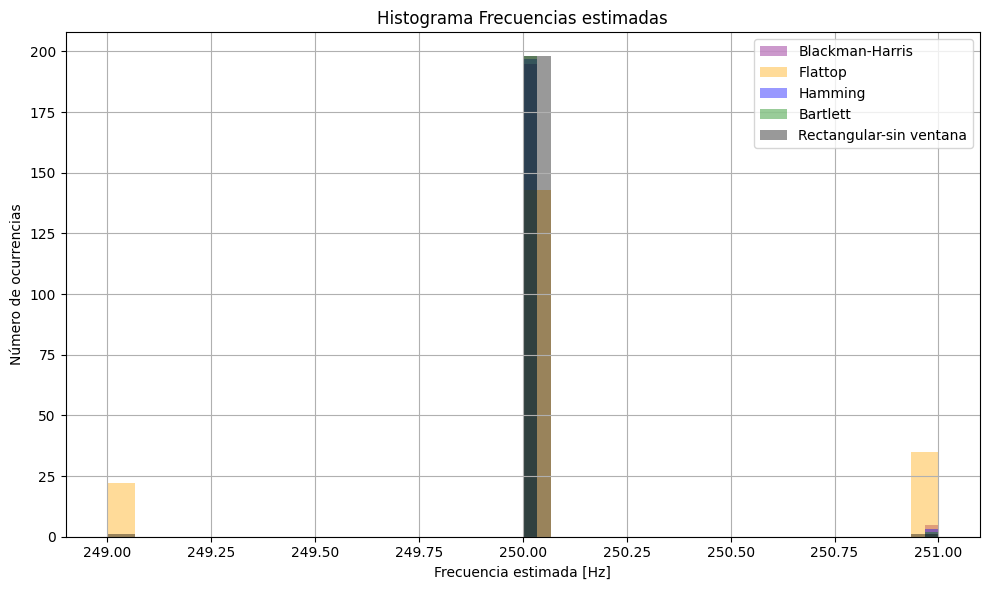

,Ventanas,Est.Amplitud-Sesgo,Est.Amplitud-Varianza,Est.Frecuencia-Sesgo,Est.Frecuencia-Varianza
0,Rectangular,-0.7996,0.0064,-0.0434,0.0100
1,Blackman-Harris,-1.1690,0.0001,-0.0184,0.0244
2,Flattop,-1.2620,0.0000,0.0216,0.2808
3,Hamming,-1.0575,0.0005,-0.0284,0.0148
4,Bartlett,-1.0848,0.0005,-0.0334,0.0099


In [8]:
resultados_3dB = analizar_ventanas(SNR=3)

# Para mostrar como tabla:
df_3dB = pd.DataFrame(resultados_3dB)
display(df_3dB.round(4))


En este caso con SNR = 3dB, vemos como la diferencia entre en el primer caso (10dB) *radica en la dispersión* de los resultados en ambos histogramas (puede evidenciarse comparando los valores de varianza entre ambos casos). Esta es **mayor cuanto menor es el valor de la SNR** (signal-to-noise ratio), ya que implica que el ruido pesa más que la señal original, haciendo que los estimadores se dispersen aún más. El análisis en cuanto a las ventanas es el mismo que el previo ya que aumenta la varianza pero ocurre en todas las ventanas. 

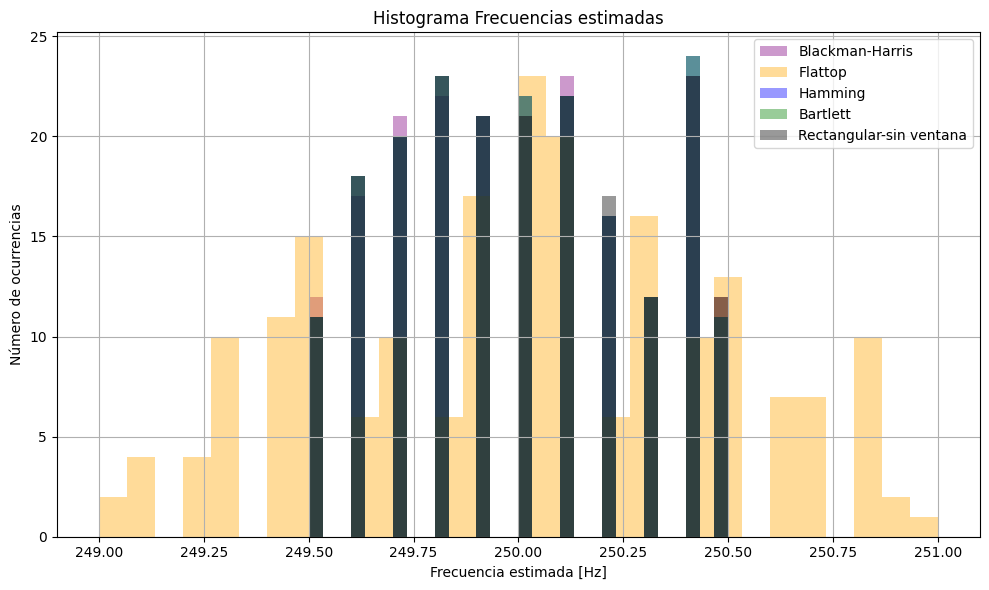

,Ventanas,Est.Frecuencia-Sesgo,Est.Frecuencia-Varianza
0,Rectangular,-0.0002,0.0861
1,Blackman-Harris,-0.0017,0.0866
2,Flattop,0.0058,0.2219
3,Hamming,-0.0017,0.0854
4,Bartlett,-0.0017,0.0854


In [13]:
resultados_10dB_p = analizar_ventanas(SNR=10,usar_zero_padding=True)

# Para mostrar como tabla:
df_10dB_p = pd.DataFrame(resultados_10dB_p)
display(df_10dB_p.round(4))

A partir de esta representación gráfica de los resultados, puede afirmarse que al aplicar el método zero-padding, en el estimador de frecuencia, brinda una mejora notable en la resolución, producto de agregar mas puntos a la interpolación. Sin embargo, como puede apreciarse en los valores esbozados en las tablas, dicha mejora se produce a expenasas de la varianza del estimador, la cual aumenta considerablemente. Entonces disminuye el valor del sesgo, porque ahora puedo estimar más cerca del valor real, pero aumenta el ruido (al agregar más puntos) lo que aumenta la varianza. 

En conclusión, con zero-padding, el estimador de frecuencia es menos sesgado pero con mayor varianza. En cuanto a las ventanas, aquellas que pueden estimar mejor la amplitud (menos varianza) no son buenas para estimar la frecuencia, como el caso de la FLattop, que como indica su nombre "aplana" el pico de amplitud lo cuál hace que sea difícil ubicar luego el máximo. 